# Model inspection:

This notebook provides a basic overview on how to load models and inspect their performance on a data set.

**Contents:**
- Loading of data
- Loading of models
- Inference on the data + Exemplary plotting
- Evaluation of metrics

In [1]:
# optional setup
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # choose cuda-device
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"  # disable preallocation of memory

import jax
#jax.config.update("jax_platform_name", "cpu")  # optionally run on cpu

In [2]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import jax.numpy as jnp

from rhmag.utils.pretest_evaluation import create_multilevel_df
from rhmag.data_management import FINAL_MATERIALS, MaterialSet, DataSet
from rhmag.utils.data_plotting import plot_sequence_prediction, plot_hysteresis_prediction
from rhmag.utils.model_evaluation import reconstruct_model_from_file, plot_model_frequency_sweep, evaluate_cross_validation
from rhmag.utils.final_data_evaluation import FINAL_SCENARIOS_PER_MATERIAL

INFO:2026-01-27 17:58:49,573:jax._src.xla_bridge:834: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2026-01-27 17:58:49 | INFO : Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## Load data:

In [3]:
FINAL_MATERIALS

['A', 'B', 'C', 'D', 'E']

In [4]:
data_set = DataSet.from_material_names(FINAL_MATERIALS)

# # if the data_set is too big for your memory you can also only load a single material:
# data_set = DataSet.from_material_names(["B"])

Loading data for B:  10%|███████████████████████▌                                                                                                                                                                                                                                | 2/21 [00:01<00:14,  1.27it/s]

Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_B.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_H.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_2_T.parquet is empty.


Loading data for B: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:02<00:00,  7.06it/s]


Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_B.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_H.parquet is empty.
Loaded DataFrame at /home/hvater/projects/RHINO-MAG/data/cache/B_6_T.parquet is empty.
Given DataFrames for B, H, and T at frequency 80000.0 are empty. Skipping this frequency for the given material.
Given DataFrames for B, H, and T at frequency 500000.0 are empty. Skipping this frequency for the given material.


Loading data for E: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.30it/s]


In [5]:
for material_set in data_set:
    print(material_set.material_name)
    for frequency_set in material_set:
        print(frequency_set.frequency)

A
50000.0
80000.0
125000.0
200000.0
320000.0
500000.0
800000.0
B
50000.0
125000.0
200000.0
320000.0
800000.0
C
50000.0
80000.0
125000.0
200000.0
320000.0
500000.0
800000.0
D
50000.0
80000.0
125000.0
200000.0
320000.0
500000.0
800000.0
E
50000.0
80000.0
125000.0
200000.0
320000.0
500000.0
800000.0


In [6]:
data_set.at_material("B")

MaterialSet(
  material_name='B',
  frequency_sets=[
    FrequencySet(
      material_name='B',
      frequency=50000.0,
      H=f32[103,32016],
      B=f32[103,32016],
      T=i32[103],
      H_RMS=f32[103]
    ),
    FrequencySet(
      material_name='B',
      frequency=125000.0,
      H=f32[1080,12816],
      B=f32[1080,12816],
      T=i32[1080],
      H_RMS=f32[1080]
    ),
    FrequencySet(
      material_name='B',
      frequency=200000.0,
      H=f32[2186,8015],
      B=f32[2186,8015],
      T=i32[2186],
      H_RMS=f32[2186]
    ),
    FrequencySet(
      material_name='B',
      frequency=320000.0,
      H=f32[1200,5008],
      B=f32[1200,5008],
      T=i32[1200],
      H_RMS=f32[1200]
    ),
    FrequencySet(
      material_name='B',
      frequency=800000.0,
      H=f32[2100,2016],
      B=f32[2100,2016],
      T=i32[2100],
      H_RMS=f32[2100]
    )
  ],
  frequencies=f32[5]
)

## Load trained models:

A small collection of models is provided together with the repository. Otherwise, your own trained models should also be available based on their experiment id (exp_id).

In [7]:
exp_ids = {
    "A": 'A_GRU8_reduced-features-f32_2a1473b6_seed12',
    "B": 'B_GRU8_reduced-features-f32_c785b2c3_seed12',
    "C": 'C_GRU8_reduced-features-f32_348e220c_seed12',
    "D": 'D_GRU8_reduced-features-f32_b6ac55b5_seed12',
    "E": 'E_GRU8_reduced-features-f32_e88a2583_seed12',
}
models = {material_name: reconstruct_model_from_file(exp_id) for material_name, exp_id in exp_ids.items()}

Found model file at '/home/hvater/projects/RHINO-MAG/data/models/A_GRU8_reduced-features-f32_2a1473b6_seed12.eqx'. Loading model..
Found model file at '/home/hvater/projects/RHINO-MAG/data/models/B_GRU8_reduced-features-f32_c785b2c3_seed12.eqx'. Loading model..
Found model file at '/home/hvater/projects/RHINO-MAG/data/models/C_GRU8_reduced-features-f32_348e220c_seed12.eqx'. Loading model..
Found model file at '/home/hvater/projects/RHINO-MAG/data/models/D_GRU8_reduced-features-f32_b6ac55b5_seed12.eqx'. Loading model..
Found model file at '/home/hvater/projects/RHINO-MAG/data/models/E_GRU8_reduced-features-f32_e88a2583_seed12.eqx'. Loading model..


## Inference + Visualization:

In [8]:
material_name = "B"  # change material name here to inspect the other models / material_sets
material_set = data_set.at_material(material_name)
model = models[material_name]

Shape of the arrays (n_sequences, sequence_length) B: (103, 2000)
Shape of the arrays (n_sequences, sequence_length) H: (103, 2000)
Shape of the arrays (n_sequences,) T: (103,)
Shape of the prediction (n_sequences, sequence_length - past_size), H_pred: (103, 1900)


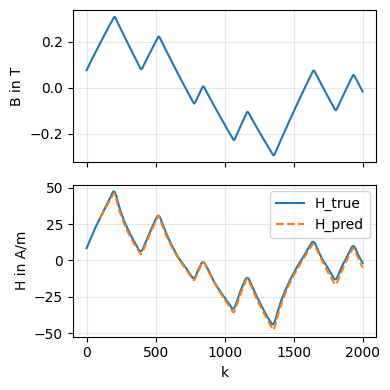

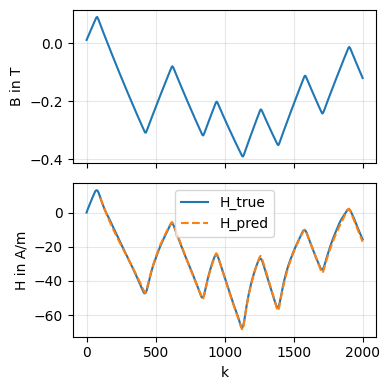

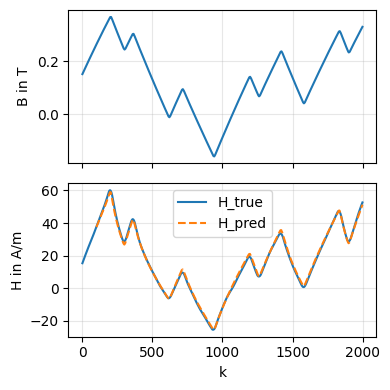

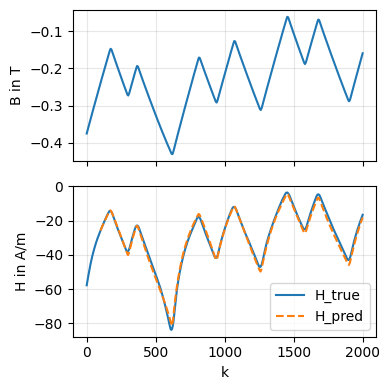

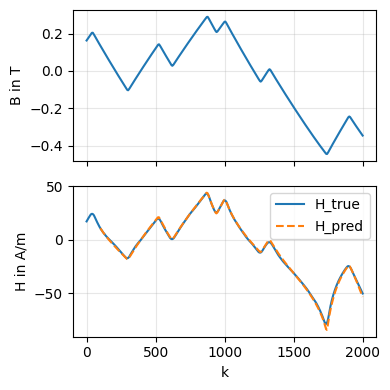

In [9]:
# choose subset of data:
past_size = 100
sequence_length = 2000
frequency = 50_000

relevant_frequency_set = material_set.at_frequency(jnp.array([frequency]))

B = relevant_frequency_set.B[:, :sequence_length]
H = relevant_frequency_set.H[:, :sequence_length]
T = relevant_frequency_set.T[:]

# prediction:
print("Shape of the arrays (n_sequences, sequence_length) B:", B.shape)
print("Shape of the arrays (n_sequences, sequence_length) H:", H.shape)
print("Shape of the arrays (n_sequences,) T:", T.shape)

H_pred = model(
    B_past=B[:, :past_size],
    B_future=B[:, past_size:],
    H_past=H[:, :past_size],
    T=T,
)

print("Shape of the prediction (n_sequences, sequence_length - past_size), H_pred:", H_pred.shape)


# visualization of predicted trajectories:
max_n_plots = 5
for idx in range(min(H_pred.shape[0], max_n_plots)):
    plot_sequence_prediction(B[idx], H[idx], T[idx], H_pred[idx], past_size=past_size, figsize=(4,4))
    plt.show()

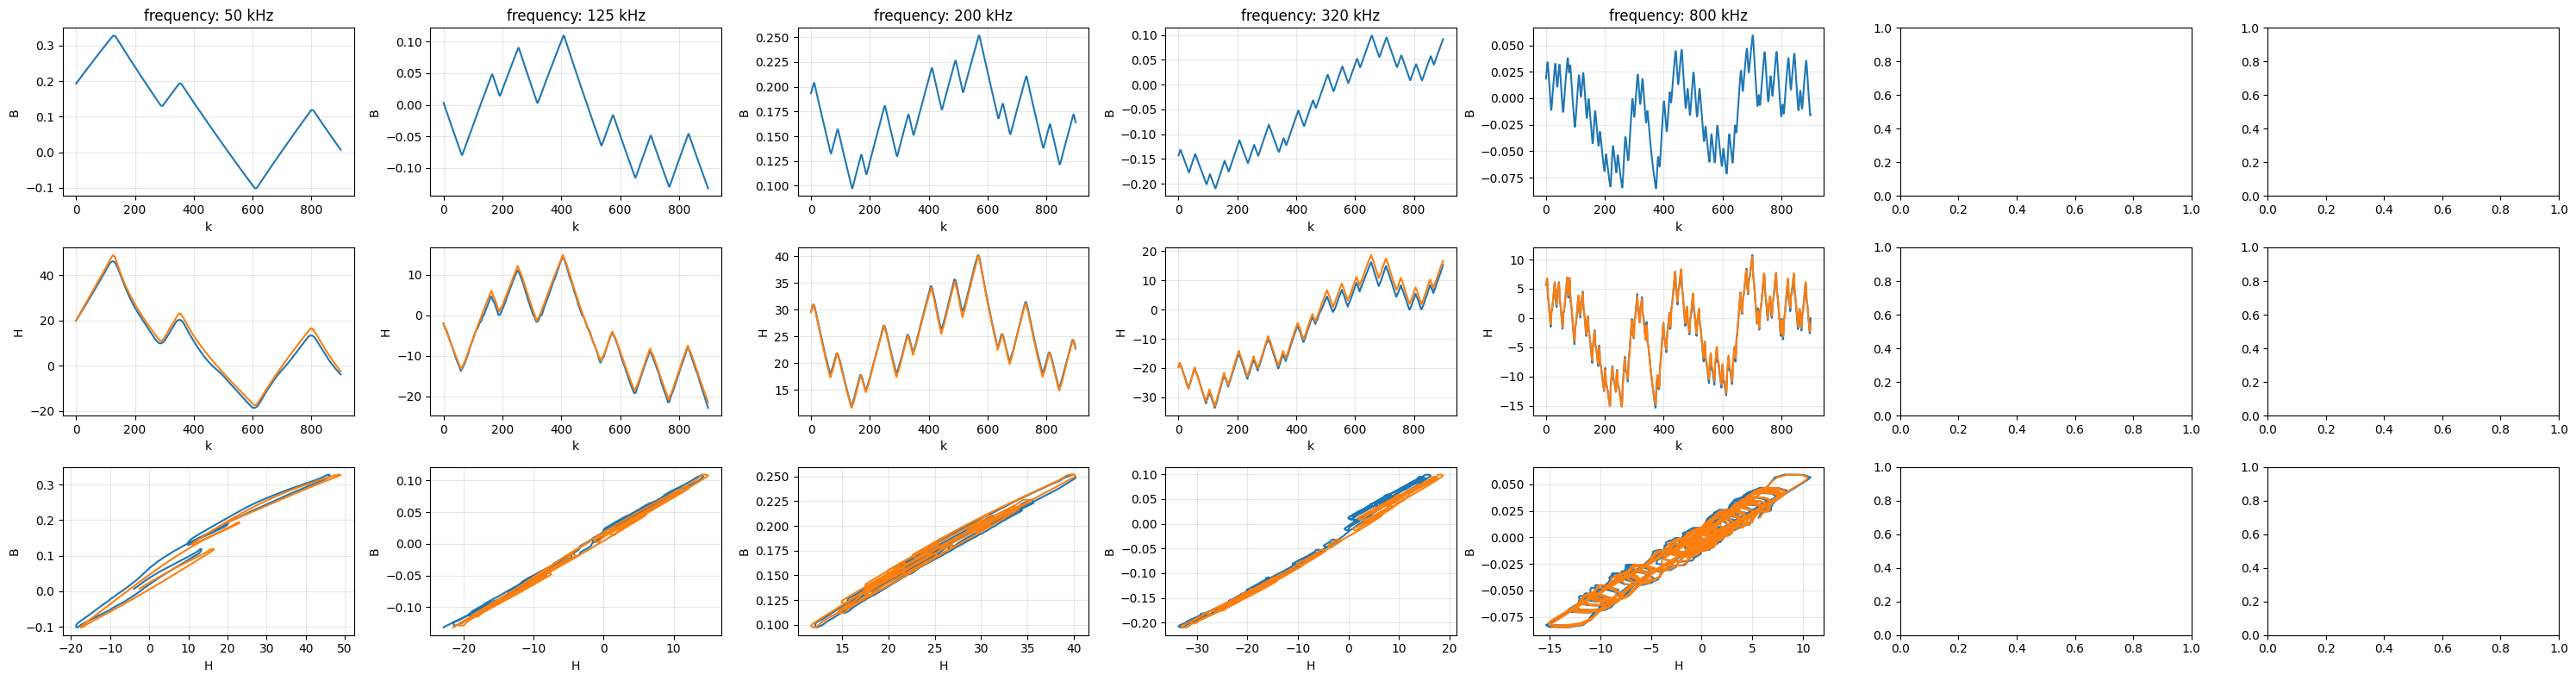

In [10]:
# run the model on all frequencies on random trajectories
loader_key = jax.random.PRNGKey(seed=12)  # key for pseudorandom sampling

plot_model_frequency_sweep(model, material_set, loader_key, past_size=100);
plt.show()

## Evaluation of metrics:

Evaluate SRE and NERE

In [11]:
train_set, val_set, test_set = material_set.split_into_train_val_test(
    train_frac=0.7, val_frac=0.15, test_frac=0.15, seed=0
)

In [12]:
metrics = evaluate_cross_validation(
    model,
    test_set,
    scenarios=FINAL_SCENARIOS_PER_MATERIAL[material_name],
    sequence_length=1000,
    batch_size_per_frequency=100,
    loader_key=jax.random.PRNGKey(0),
)

Normalized Energy relative error cannot be properly computed as the core losses are unknown. Setting 'true_core_loss=1'.
Normalized Energy relative error cannot be properly computed as the core losses are unknown. Setting 'true_core_loss=1'.
Normalized Energy relative error cannot be properly computed as the core losses are unknown. Setting 'true_core_loss=1'.
	MSE :    1.84 (A/m)²
	WCE :   55.22 A/m
	MSE :    5.34 (A/m)²
	WCE :   55.23 A/m
	MSE :    2.96 (A/m)²
	WCE :   41.26 A/m


In [13]:
df_models_3C90 = create_multilevel_df(
    {
        exp_ids[material_name]: metrics,
    }
)
display(HTML(df_models_3C90.T.to_html(float_format="%.4f", bold_rows=False)))